<a href="https://colab.research.google.com/github/douglasmmachado/MedicineConsumption/blob/main/notebooks/causal_method/unified_approach/tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Removing outliers, understanding the data, visualization of components for each dataset, common period for the different hospitals, data aggregation and transformation of categorical features into numerical ones.

---



---



# Loading libs and database

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import math as m

df_url ="https://raw.githubusercontent.com/douglasmmachado/ExploratoryDataAnalysis/main/datasets/unified_approach/df_unified.csv"


df = pd.read_csv(df_url)



categorical_features = ['ID_REF', 'ID_SITE_RATTACHE', 'CODE_ATC', 'HOSPI_CODE_UCD']
date_features = ['DATE_MOUV', 'WEEK', 'MONTH', 'YEAR']
numerical_features = ['N_UFS', 'QUANTITY', 'N_ETB', 'POPULATION', 'P_MEDICAL', 'PN_MEDICAL', 'LIT_HC', 'LIT_HP', 'SEJ_MCO', 'SEJ_HAD', 'SEJ_PSY', 'SEJ_SSR']

df['DATE_MOUV'] = pd.to_datetime(df['DATE_MOUV'],
              format='%Y-%m-%d')  # Changed the type of date too

for column in categorical_features:
  df[column] = df[column].astype('string')

df = df.drop(['ID_REF', 'CODE_ATC', 'WEEK'], axis=1)

## 2.1 - Visualisation of data range and data composition

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75684 entries, 0 to 75683
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_SITE_RATTACHE  75684 non-null  string        
 1   HOSPI_CODE_UCD    75684 non-null  string        
 2   DATE_MOUV         75684 non-null  datetime64[ns]
 3   N_UFS             75684 non-null  int64         
 4   QUANTITY          75684 non-null  float64       
 5   MONTH             75684 non-null  int64         
 6   YEAR              75684 non-null  int64         
 7   N_ETB             75684 non-null  int64         
 8   POPULATION        75684 non-null  float64       
 9   P_MEDICAL         75684 non-null  int64         
 10  PN_MEDICAL        75684 non-null  int64         
 11  LIT_HC            75684 non-null  float64       
 12  LIT_HP            75684 non-null  float64       
 13  SEJ_MCO           75684 non-null  int64         
 14  SEJ_HAD           7568

## 2.2 - Removing outliers by hospital and by drug

In [3]:
def remove_outliers(df, columns, verbose=False, hospital = ''):
    N_macro = df.shape[0]
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the filtered values
    removed_outliers = 0  # Variable to keep track of the total number of removed outliers

    for col in columns:
        for ucd_code in df['HOSPI_CODE_UCD'].unique():
            # Filter the dataframe for the specific HOSPI_CODE_UCD
            df_subset = df[df['HOSPI_CODE_UCD'] == ucd_code]
            N = df_subset.shape[0]

            # Calculate the statistics for the column within the HOSPI_CODE_UCD subset
            q25, q75 = np.percentile(df_subset[col], [25, 75])
            iqr = q75 - q25
            lower, upper = q25 - (iqr * 1.5), q75 + (iqr * 1.5)

            # Remove outliers based on the cutoff values within the HOSPI_CODE_UCD subset
            df_filtered = df_subset[(df_subset[col] >= lower) & (df_subset[col] <= upper)]
            N_new = df_filtered.shape[0]
            delta = N - N_new

            # Update the new DataFrame with the filtered values
            new_df = pd.concat([new_df, df_filtered])

            if verbose:
                if delta > 0:
                    print(f'Column: {col}')
                    print(f'HOSPI_CODE_UCD: {ucd_code}')
                    print(f'Removed outliers: {delta}')
                    print(f'Removed percentage: {(100 * delta / N):.3}%')
                    print()

            removed_outliers += delta

    print(f'Hospital: {hospital}')
    new_df.reset_index(drop=True, inplace=True)
    print('N_old:', N_macro)
    N_macro_new = new_df.shape[0]
    print('N_new:', N_macro_new)
    delta = N_macro - N_macro_new
    print(f'Total removed outliers: {(100 * delta / N_macro):.3}%')
    print()

    return new_df


In [4]:
print("-"*100)
df_wo_outliers = pd.concat([remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_1'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_1'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_2'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_2'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_3'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_3'),
                                remove_outliers(df[df['ID_SITE_RATTACHE']=='HOSPI_4'], ["QUANTITY"], verbose = False, hospital = 'HOSPI_4')])

print()
df_wo_outliers.info()

----------------------------------------------------------------------------------------------------
Hospital: HOSPI_1
N_old: 22725
N_new: 21715
Total removed outliers: 4.44%

Hospital: HOSPI_2
N_old: 15439
N_new: 14953
Total removed outliers: 3.15%

Hospital: HOSPI_3
N_old: 27591
N_new: 26801
Total removed outliers: 2.86%

Hospital: HOSPI_4
N_old: 9929
N_new: 9638
Total removed outliers: 2.93%


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73107 entries, 0 to 9637
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_SITE_RATTACHE  73107 non-null  string        
 1   HOSPI_CODE_UCD    73107 non-null  string        
 2   DATE_MOUV         73107 non-null  datetime64[ns]
 3   N_UFS             73107 non-null  int64         
 4   QUANTITY          73107 non-null  float64       
 5   MONTH             73107 non-null  int64         
 6   YEAR              73107 non-null  int64         
 7   N

## 2.3 - Define common period for data usage

In [5]:
# Group by ID_SITE_RATTACHE and calculate min and max dates
min_dates = df_wo_outliers.groupby('ID_SITE_RATTACHE')['DATE_MOUV'].min()
max_dates = df_wo_outliers.groupby('ID_SITE_RATTACHE')['DATE_MOUV'].max()

# Print min and max dates for each hospital
print("Min dates:")
for hospital, min_date in min_dates.items():
    print(f"{hospital}: {min_date}")

print("\nMax dates:")
for hospital, max_date in max_dates.items():
    print(f"{hospital}: {max_date}")

# Calculate overall min and max dates
init = min_dates.min()
ending = max_dates.max()

print(f"\nOverall Min Date: {init}")
print(f"Overall Max Date: {ending}")

common_period = pd.date_range(start=pd.Timestamp(year=init.year, month=init.month, day=1), end=pd.Timestamp(year=ending.year, month=ending.month, day=31))
df_cp = df_wo_outliers[(df_wo_outliers["DATE_MOUV"] >= init) & (df_wo_outliers["DATE_MOUV"] <= ending)].copy()

Min dates:
HOSPI_1: 2013-06-18 00:00:00
HOSPI_2: 2017-03-30 00:00:00
HOSPI_3: 2014-05-20 00:00:00
HOSPI_4: 2016-01-01 00:00:00

Max dates:
HOSPI_1: 2019-12-30 00:00:00
HOSPI_2: 2019-12-30 00:00:00
HOSPI_3: 2019-12-30 00:00:00
HOSPI_4: 2019-03-05 00:00:00

Overall Min Date: 2013-06-18 00:00:00
Overall Max Date: 2019-12-30 00:00:00


## 2.4 - Fill gaps in data for eache medicine and for each hospital

In [6]:
def fill_gap_timeseries(df_cp, common_period,hospital='', visu=False):
    for medicine in df.HOSPI_CODE_UCD.unique():

        data = {
            'DATE_MOUV': list(common_period),
            'HOSPI_CODE_UCD': [medicine] * len(common_period)
        }

        df_medicine = pd.DataFrame(data)

        df_medicine_resampled = pd.merge(df_medicine, df_cp.astype({'DATE_MOUV': 'datetime64[ns]'}),
                                         on=['DATE_MOUV', 'HOSPI_CODE_UCD'], how='left')

        df_medicine_resampled = pd.merge(df_medicine, df_cp, on=['DATE_MOUV', 'HOSPI_CODE_UCD'], how='left')
        df_medicine_resampled['N_ETB'] = df_medicine_resampled['N_ETB'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['N_UFS'] = df_medicine_resampled['N_UFS'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['POPULATION'] = df_medicine_resampled['POPULATION'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['P_MEDICAL'] = df_medicine_resampled['P_MEDICAL'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['PN_MEDICAL'] = df_medicine_resampled['PN_MEDICAL'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['LIT_HC'] = df_medicine_resampled['LIT_HC'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['LIT_HP'] = df_medicine_resampled['LIT_HP'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_MCO'] = df_medicine_resampled['SEJ_MCO'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_HAD'] = df_medicine_resampled['SEJ_HAD'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_PSY'] = df_medicine_resampled['SEJ_PSY'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_SSR'] = df_medicine_resampled['SEJ_SSR'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['SEJ_SLD'] = df_medicine_resampled['SEJ_SLD'].fillna(method='bfill').fillna(method='ffill')
        df_medicine_resampled['QUANTITY'] = df_medicine_resampled['QUANTITY'].fillna(0)

        df_cp = df_cp[df_cp["HOSPI_CODE_UCD"] != medicine]
        df_cp = pd.concat([df_cp, df_medicine_resampled], ignore_index=True)

    df_cp = df_cp.sort_values(by=['DATE_MOUV']).reset_index(drop=True)
    df_cp["WEEK"] = df_cp["DATE_MOUV"].dt.isocalendar().week
    df_cp["YEAR"] = df_cp["DATE_MOUV"].dt.year
    df_cp["MONTH"] = df_cp["DATE_MOUV"].dt.month
    df_cp["ID_SITE_RATTACHE"] = hospital
    x = common_period

    if visu:
        fig, axs = plt.subplots(7, 3, figsize=(25, 25))

        for i, medicine in enumerate(df.HOSPI_CODE_UCD.unique()):
            row = i // 3  # Calculate the row index
            col = i % 3   # Calculate the column index

            ax = axs[row, col]  # Get the corresponding subplot

            y = df_cp[df_cp["HOSPI_CODE_UCD"] == medicine]["QUANTITY"]
            ax.scatter(x, y)
            ax.set_title(f'Consumption quantity of medicine: {medicine} per day')
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.grid()

        plt.tight_layout()
        plt.show()

    return df_cp


In [7]:
df_h1_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_1'].copy(), common_period, 'HOSPI_1')
df_h2_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_2'].copy(), common_period, 'HOSPI_2')
df_h3_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_3'].copy(), common_period, 'HOSPI_3')
df_h4_cp_filled = fill_gap_timeseries(df_cp[df_cp['ID_SITE_RATTACHE'] == 'HOSPI_4'].copy(), common_period, 'HOSPI_4')

df_cp_filled = pd.concat([df_h1_cp_filled, df_h2_cp_filled, df_h3_cp_filled, df_h4_cp_filled])
df_cp_filled = df_cp_filled.sort_values(by=['DATE_MOUV', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE']).reset_index(drop=True)
df_cp_filled

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,DATE_MOUV,N_UFS,QUANTITY,MONTH,YEAR,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD,WEEK
0,HOSPI_1,3400890837149,2013-06-01,1.0,0.0,6,2013,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0,22
1,HOSPI_2,3400890837149,2013-06-01,1.0,0.0,6,2013,5.0,539067.0,714.0,5001.0,1157.0,187.0,75420.0,0.0,1236.0,261.0,0.0,22
2,HOSPI_3,3400890837149,2013-06-01,2.0,0.0,6,2013,50.0,1107398.0,1158.0,7129.0,2063.0,521.0,117781.0,594.0,2903.0,1302.0,97.0,22
3,HOSPI_4,3400890837149,2013-06-01,1.0,0.0,6,2013,39.0,1835903.0,2526.0,15604.0,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0,22
4,HOSPI_1,3400891191226,2013-06-01,1.0,0.0,6,2013,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202018,HOSPI_4,3400893826706,2019-12-31,1.0,0.0,12,2019,39.0,1871364.0,2639.0,15774.0,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0,1
202019,HOSPI_1,3400893875490,2019-12-31,1.0,0.0,12,2019,12.0,569894.0,843.0,5438.0,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0,1
202020,HOSPI_2,3400893875490,2019-12-31,23.0,0.0,12,2019,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0,1
202021,HOSPI_3,3400893875490,2019-12-31,14.0,0.0,12,2019,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0,1


## 2.5 - Aggregate data by drug, hospital, year and month

In [8]:
def aggregate_dataframe(df):

    df['DATE'] = df['DATE_MOUV'].dt.strftime('%Y-%m')
    df.drop('DATE_MOUV', axis=1, inplace=True)

    df = df.groupby(["ID_SITE_RATTACHE", "HOSPI_CODE_UCD", "YEAR", "MONTH"], as_index=False).agg({
        'QUANTITY': np.sum,
        'N_UFS': np.median,
        'DATE':'first',
        'N_ETB': np.median,
        'POPULATION': np.median,
        'P_MEDICAL': np.median,
        'PN_MEDICAL': np.median,
        'LIT_HC': np.median,
        'LIT_HP': np.median,
        'SEJ_MCO': np.median,
        'SEJ_HAD': np.median,
        'SEJ_PSY': np.median,
        'SEJ_SSR': np.median,
        'SEJ_SLD': np.median
    })

    df.sort_values(by=['DATE', 'HOSPI_CODE_UCD', 'ID_SITE_RATTACHE'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [9]:
# Grouping the different datasets divided by hospital
df_aggregated = aggregate_dataframe(df_cp_filled.copy())
df_aggregated

,ID_SITE_RATTACHE,HOSPI_CODE_UCD,YEAR,MONTH,QUANTITY,N_UFS,DATE,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,SEJ_MCO,SEJ_HAD,SEJ_PSY,SEJ_SSR,SEJ_SLD
0,HOSPI_1,3400890837149,2013,6,0.0,1.0,2013-06,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
1,HOSPI_2,3400890837149,2013,6,0.0,1.0,2013-06,5.0,539067.0,714.0,5001.0,1157.0,187.0,75420.0,0.0,1236.0,261.0,0.0
2,HOSPI_3,3400890837149,2013,6,0.0,2.0,2013-06,50.0,1107398.0,1158.0,7129.0,2063.0,521.0,117781.0,594.0,2903.0,1302.0,97.0
3,HOSPI_4,3400890837149,2013,6,0.0,1.0,2013-06,39.0,1835903.0,2526.0,15604.0,4536.0,470.0,247827.0,0.0,22.0,7902.0,163.0
4,HOSPI_1,3400891191226,2013,6,10.0,1.0,2013-06,12.0,571675.0,683.0,5270.0,1471.0,112.0,72785.0,0.0,0.0,1049.0,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6631,HOSPI_4,3400893826706,2019,12,0.0,1.0,2019-12,39.0,1871364.0,2639.0,15774.0,4530.0,514.0,263011.0,0.0,770.0,8031.0,172.0
6632,HOSPI_1,3400893875490,2019,12,0.0,1.0,2019-12,12.0,569894.0,843.0,5438.0,1353.0,100.0,82997.0,0.0,0.0,1141.0,92.0
6633,HOSPI_2,3400893875490,2019,12,6870.0,12.0,2019-12,5.0,542302.0,706.0,5013.0,1141.0,141.0,76593.0,0.0,1007.0,206.0,0.0
6634,HOSPI_3,3400893875490,2019,12,12144.0,15.0,2019-12,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,116793.0,1099.0,2297.0,1169.0,124.0


## 2.6 - Visualize period and replace outliers with median

In [10]:
df_resampled = df_aggregated.copy()

In [11]:
import plotly.express as px

for medicine in df_resampled['HOSPI_CODE_UCD'].unique():
    filtered_df = df_resampled[df_resampled['HOSPI_CODE_UCD'] == medicine]

    fig = px.scatter(filtered_df, x='DATE', y='QUANTITY', color='ID_SITE_RATTACHE',
                     title=f'Scatter Plot of Quantity vs. Date for medicine {medicine}',
                     labels={'DATE': 'DATE', 'QUANTITY': 'QUANTITY'},
                     width=1000, height=600)

    fig.update_layout(xaxis=dict(showgrid=True, tickangle=-45),
                      yaxis=dict(showgrid=True),
                      showlegend=True)

    fig.show()
    print()

## 2.7 - Transform categorical features

In [12]:
hospi_codes = df_resampled['ID_SITE_RATTACHE'].values
df_encoded = pd.get_dummies(df_resampled, columns=['MONTH', 'YEAR', 'ID_SITE_RATTACHE'], prefix=['MONTH', 'YEAR', 'HOSPI'], drop_first=True)
df_encoded['ID_SITE_RATTACHE'] = hospi_codes
df_encoded

,HOSPI_CODE_UCD,QUANTITY,N_UFS,DATE,N_ETB,POPULATION,P_MEDICAL,PN_MEDICAL,LIT_HC,LIT_HP,...,YEAR_2014,YEAR_2015,YEAR_2016,YEAR_2017,YEAR_2018,YEAR_2019,HOSPI_HOSPI_2,HOSPI_HOSPI_3,HOSPI_HOSPI_4,ID_SITE_RATTACHE
0,3400890837149,0.0,1.0,2013-06,12.0,571675.0,683.0,5270.0,1471.0,112.0,...,0,0,0,0,0,0,0,0,0,HOSPI_1
1,3400890837149,0.0,1.0,2013-06,5.0,539067.0,714.0,5001.0,1157.0,187.0,...,0,0,0,0,0,0,1,0,0,HOSPI_2
2,3400890837149,0.0,2.0,2013-06,50.0,1107398.0,1158.0,7129.0,2063.0,521.0,...,0,0,0,0,0,0,0,1,0,HOSPI_3
3,3400890837149,0.0,1.0,2013-06,39.0,1835903.0,2526.0,15604.0,4536.0,470.0,...,0,0,0,0,0,0,0,0,1,HOSPI_4
4,3400891191226,10.0,1.0,2013-06,12.0,571675.0,683.0,5270.0,1471.0,112.0,...,0,0,0,0,0,0,0,0,0,HOSPI_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6631,3400893826706,0.0,1.0,2019-12,39.0,1871364.0,2639.0,15774.0,4530.0,514.0,...,0,0,0,0,0,1,0,0,1,HOSPI_4
6632,3400893875490,0.0,1.0,2019-12,12.0,569894.0,843.0,5438.0,1353.0,100.0,...,0,0,0,0,0,1,0,0,0,HOSPI_1
6633,3400893875490,6870.0,12.0,2019-12,5.0,542302.0,706.0,5013.0,1141.0,141.0,...,0,0,0,0,0,1,1,0,0,HOSPI_2
6634,3400893875490,12144.0,15.0,2019-12,50.0,1171739.0,1318.0,7578.0,2011.0,529.0,...,0,0,0,0,0,1,0,1,0,HOSPI_3


# 3 - Understanding feautures and selecting the most important ones regarding the consumption

In [13]:
medicines = ['3400892088310','3400892075761','3400892203645',
             '3400892065366','3400892052120','3400891996128',
             '3400893826706','3400893736135','3400893875490',
             '3400890837149','3400891235203','3400891225037',
             '3400891191226','3400892729589','3400892745848',
             '3400892697789','3400892761527','3400893022634',
             '3400892761695','3400892669236','3400892508566']

In [14]:
import pandas as pd
import numpy as np

def calculate_moving_average(df, column, period):
    df_copy = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

    # Iterate over each unique value of 'HOSPI_CODE_UCD' (medicine)
    for medicine in df_copy['HOSPI_CODE_UCD'].unique():
        mask = df_copy['HOSPI_CODE_UCD'] == medicine
        ma_column = column + '_MA'

        # Calculate the moving average
        vector = df_copy.loc[mask, column].values

        # Use pandas rolling() function to calculate the moving average
        moving_average = pd.Series(vector).rolling(window=period).mean()

        # Store the moving average values in the DataFrame
        df_copy.loc[mask, ma_column] = moving_average

    return df_copy


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_ma(df, column, period):
    df_copy = df.copy()
    df_copy['DATE'] = pd.to_datetime(df_copy['DATE'])

    plt.figure(figsize=(15, 8))

    # Group the data by 'HOSPI_CODE_UCD'
    grouped_df = df_copy.groupby('HOSPI_CODE_UCD')

    # Create subplots for each group
    for code, group in grouped_df:
        group['MA'] = group[column].rolling(window=period, min_periods=1).mean()
        plt.plot(group['DATE'], group['MA'], linewidth=2, label=f'Medicine {code}')

    plt.xlabel('DATE')
    plt.ylabel('Quantity')
    plt.title(f'Scatter Plot of Quantity Moving Average for the Period of: {period} months')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='Medicine')
    plt.grid(True)
    plt.show()

# Example usage:
# scatterplot_quantity(df, 'QUANTITY', 3)  # Replace df with your DataFrame


In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

def ts_features(df):
    for hospital in df.ID_SITE_RATTACHE.unique():
        for medicine in medicines:
            series = df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["QUANTITY"]
            series.index = pd.to_datetime(df[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital)]["DATE"])
            result = seasonal_decompose(series, model='additive', period = 6)
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "TREND"] = result.trend.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "SEASONAL"] = result.seasonal.values
            df.loc[(df["HOSPI_CODE_UCD"] == medicine) & (df["ID_SITE_RATTACHE"] == hospital), "RESID"] = result.resid.values
    df.fillna(0, inplace=True)  # Replace NaN values with zero

In [17]:
ts_features(df_encoded)

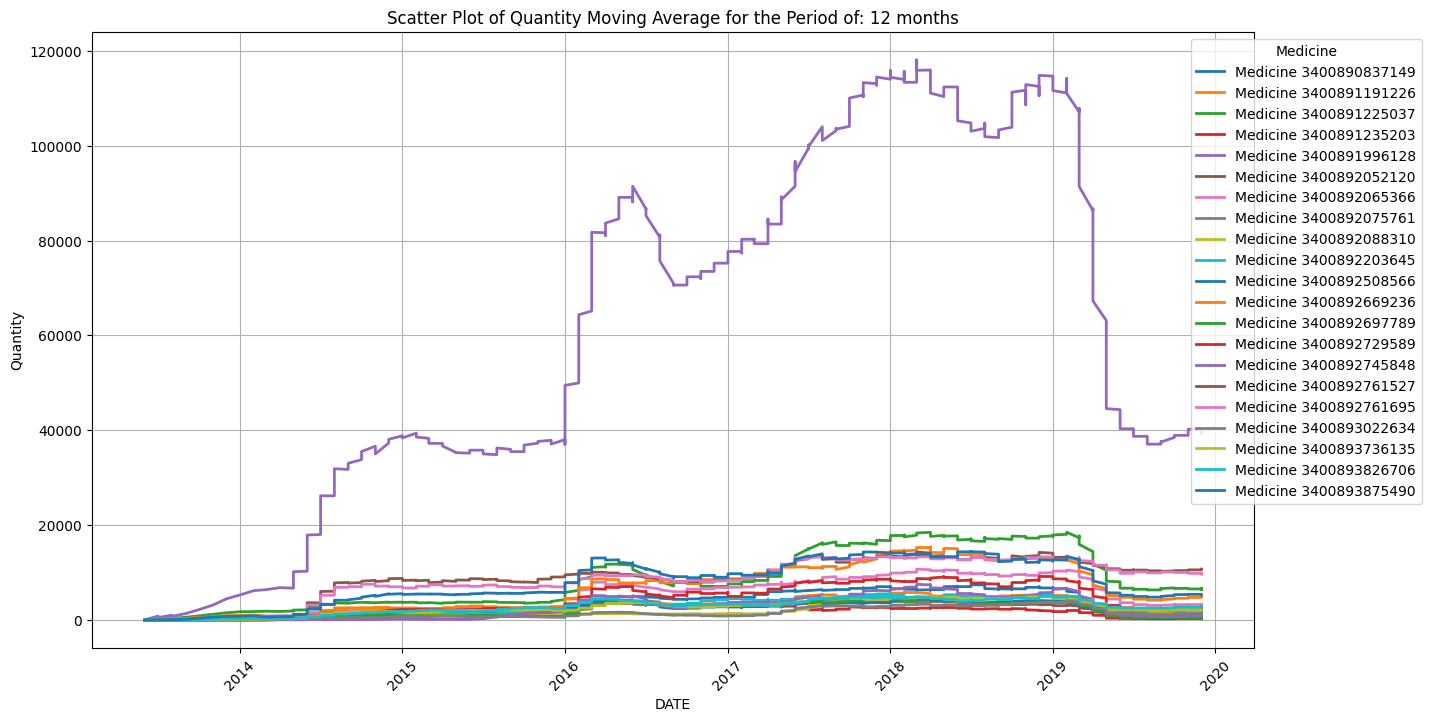

In [18]:
df_ma_6 = calculate_moving_average(df_encoded.copy(), 'QUANTITY', 12)
df_ma_6 = df_ma_6.sort_index(axis=1).reset_index(drop=True)
plot_ma(df_ma_6, 'QUANTITY', 12)

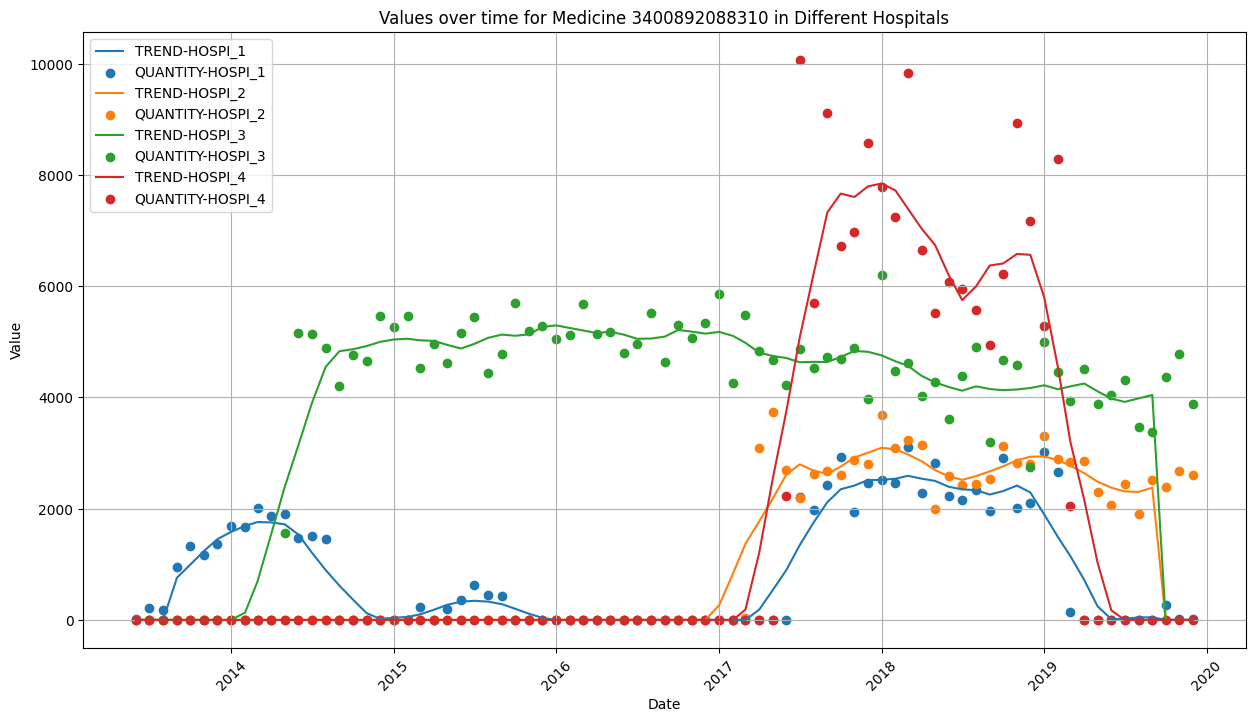

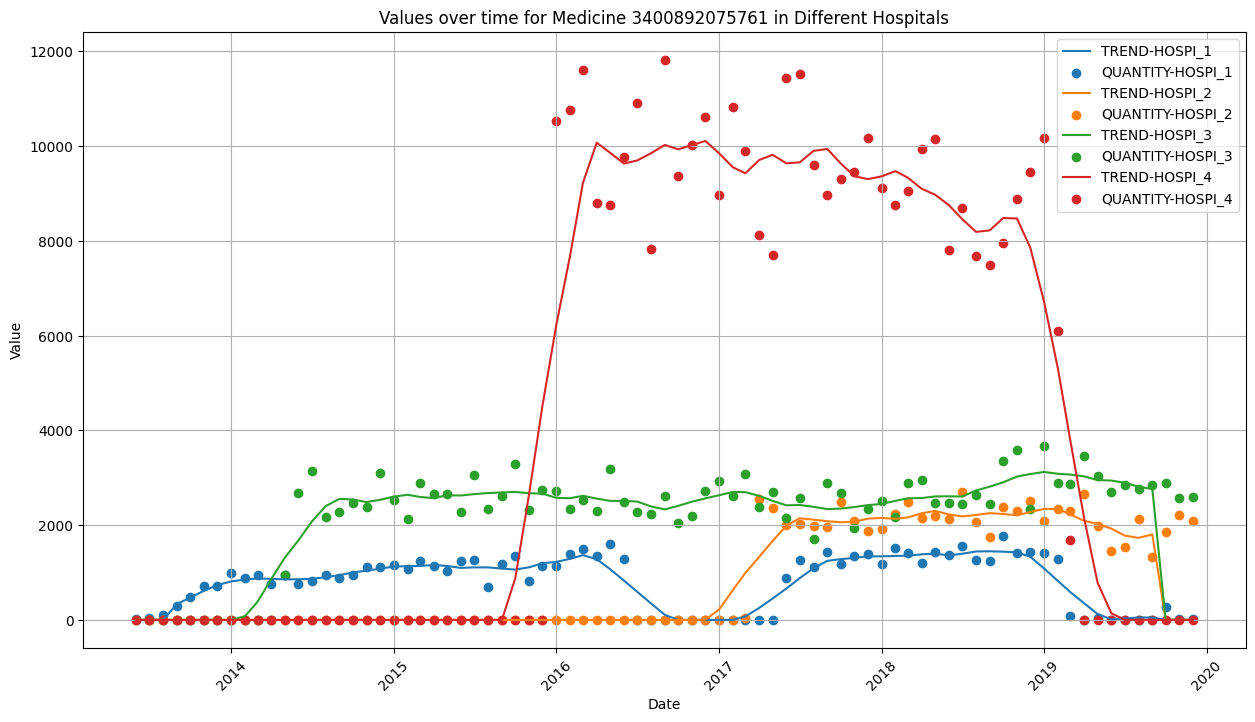

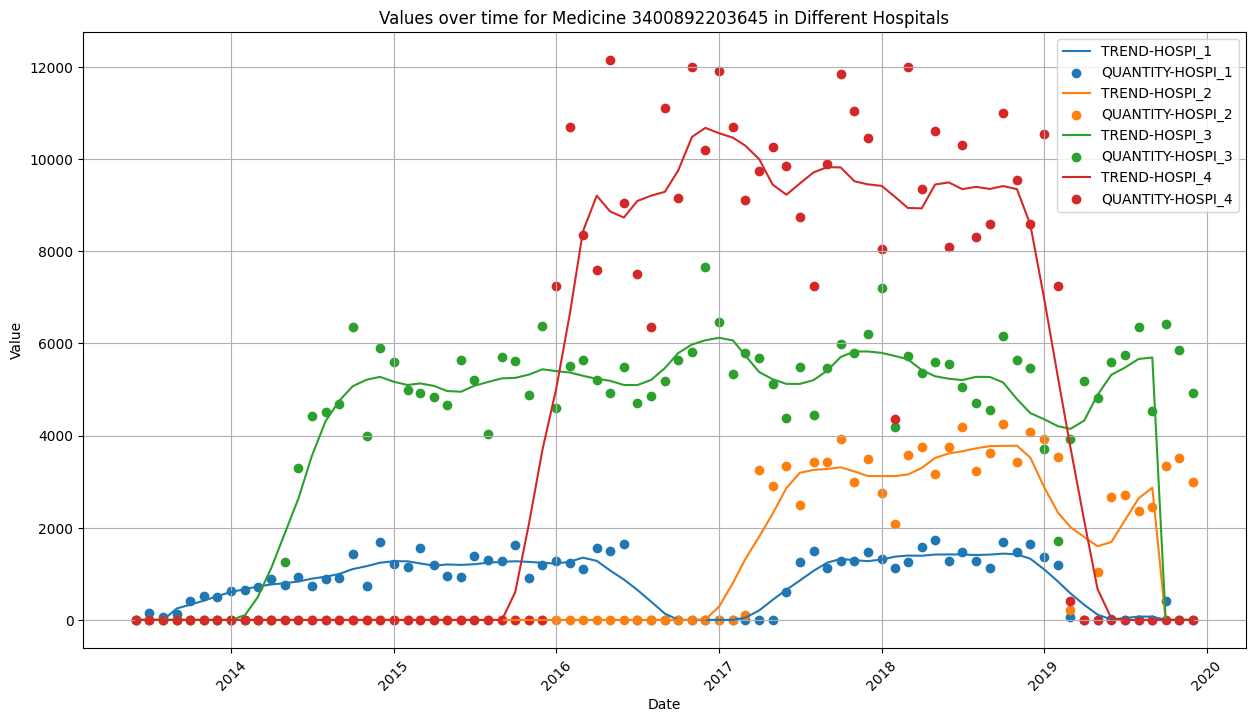

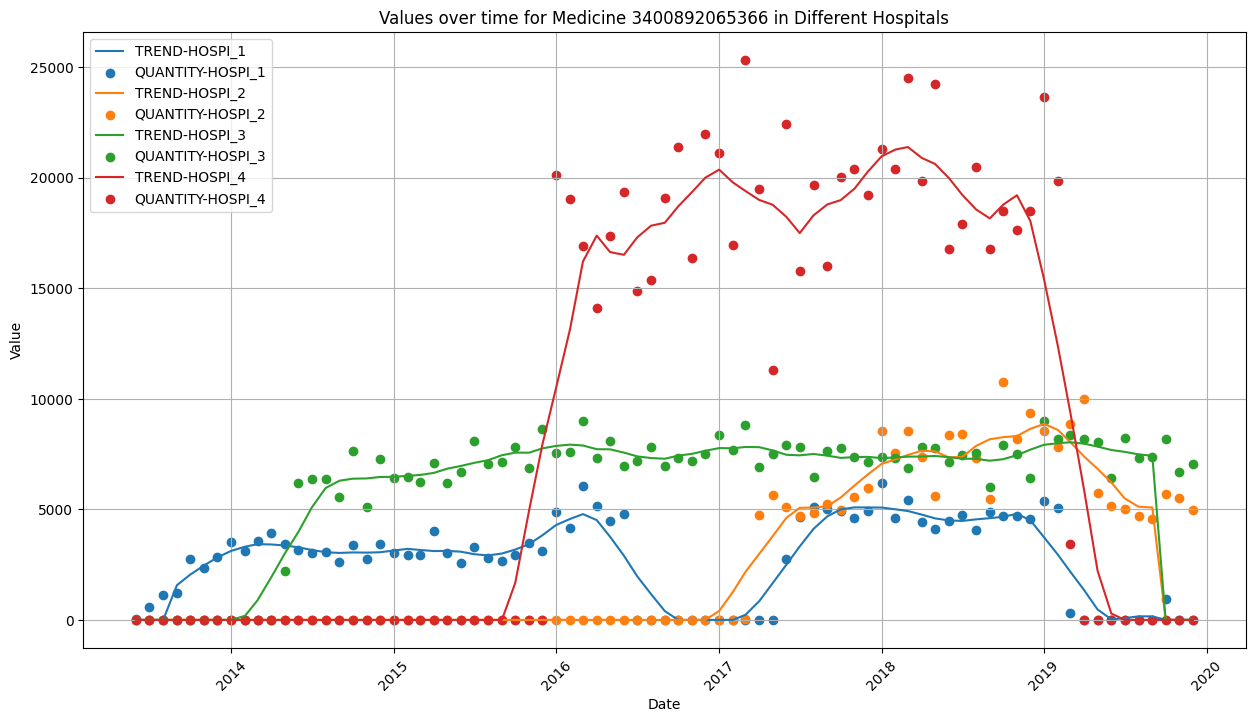

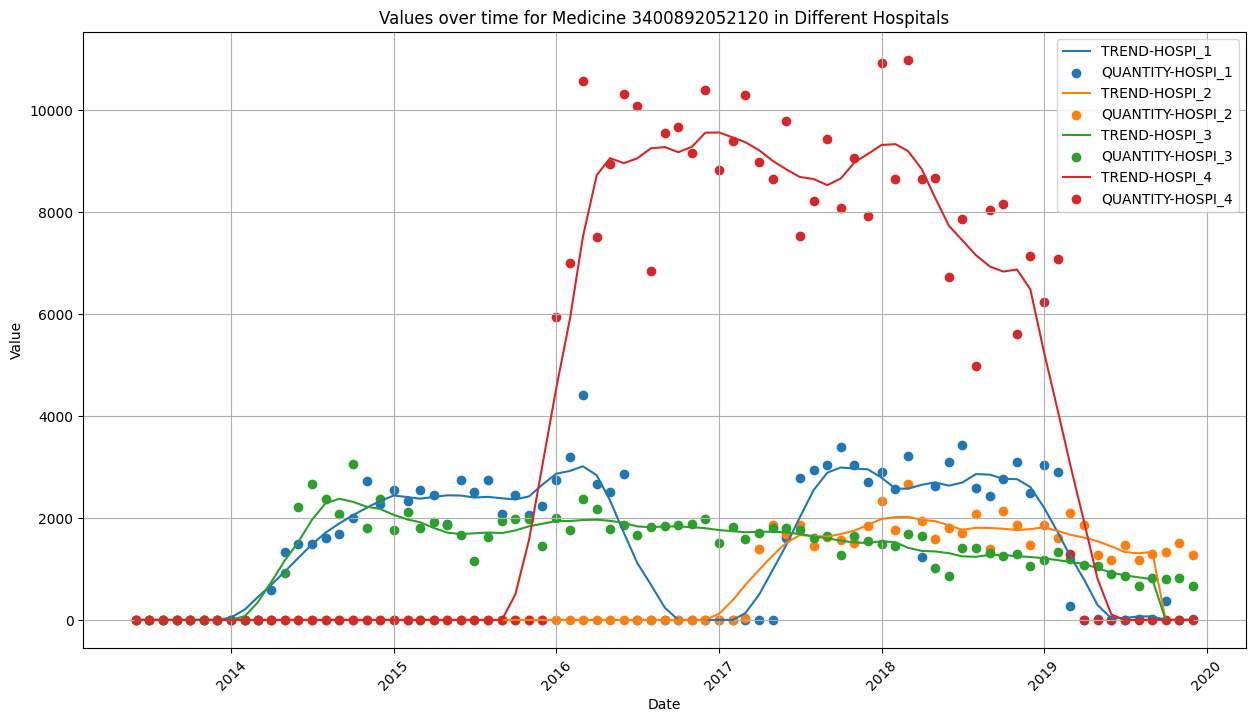

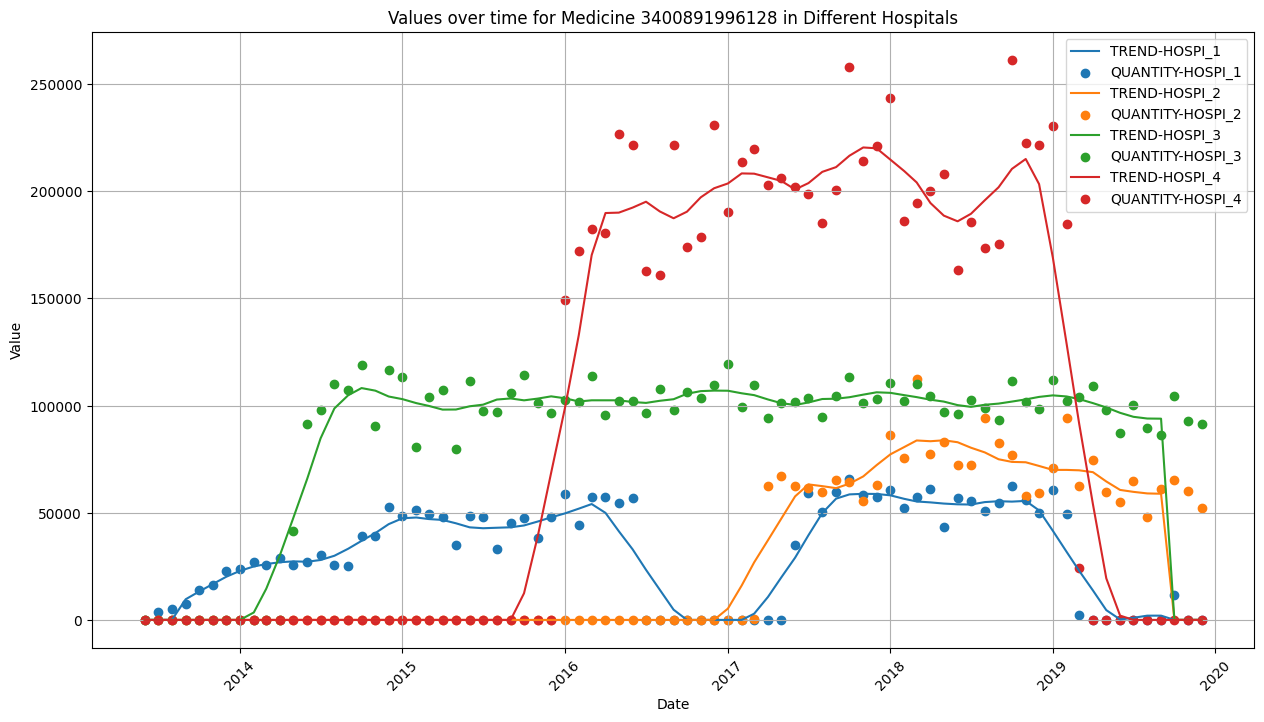

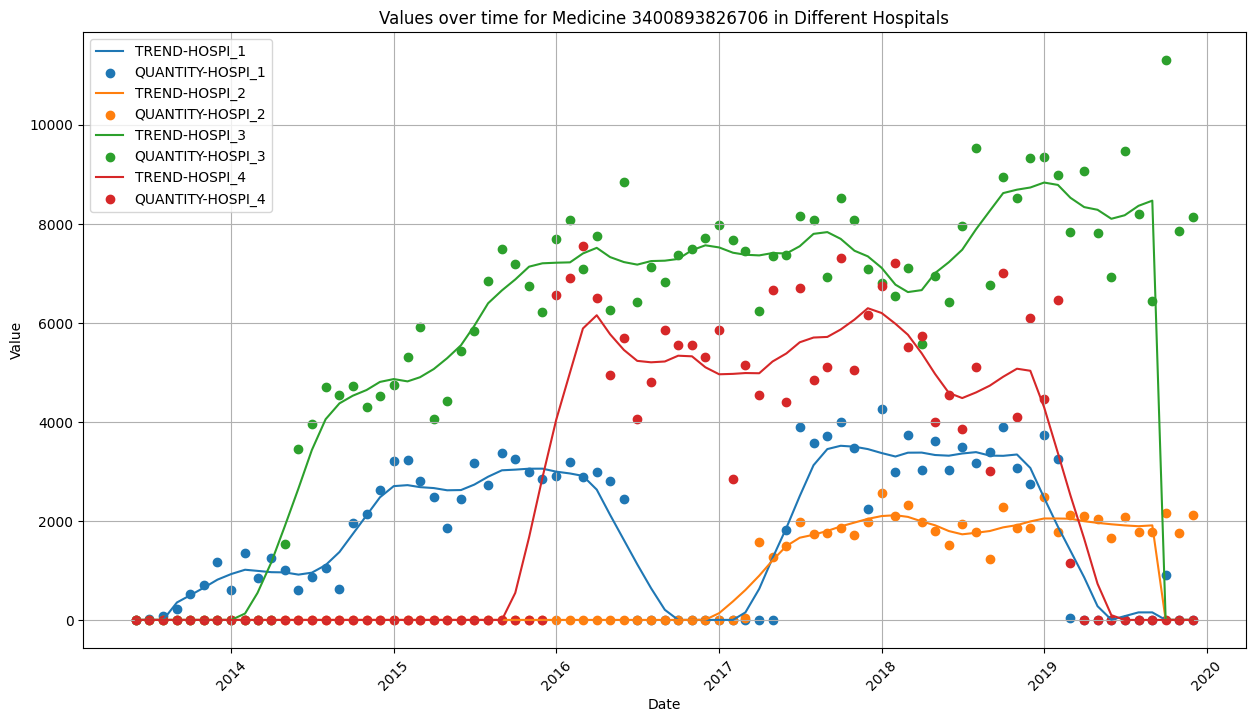

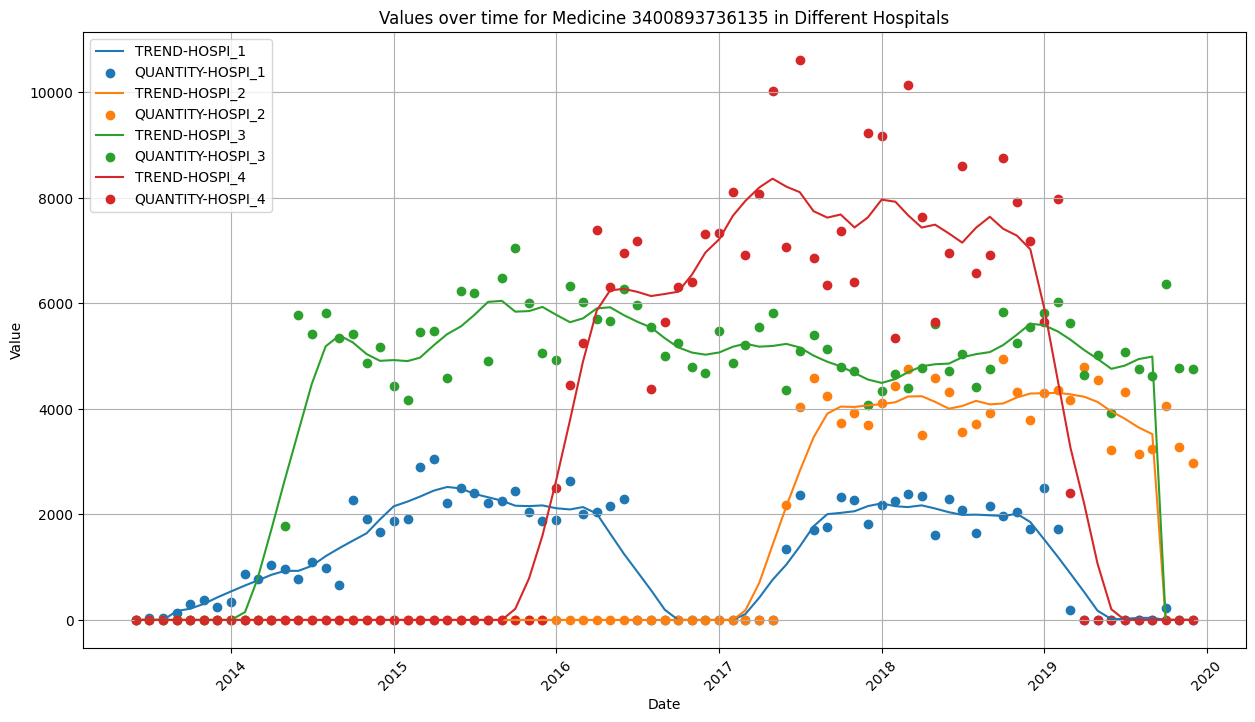

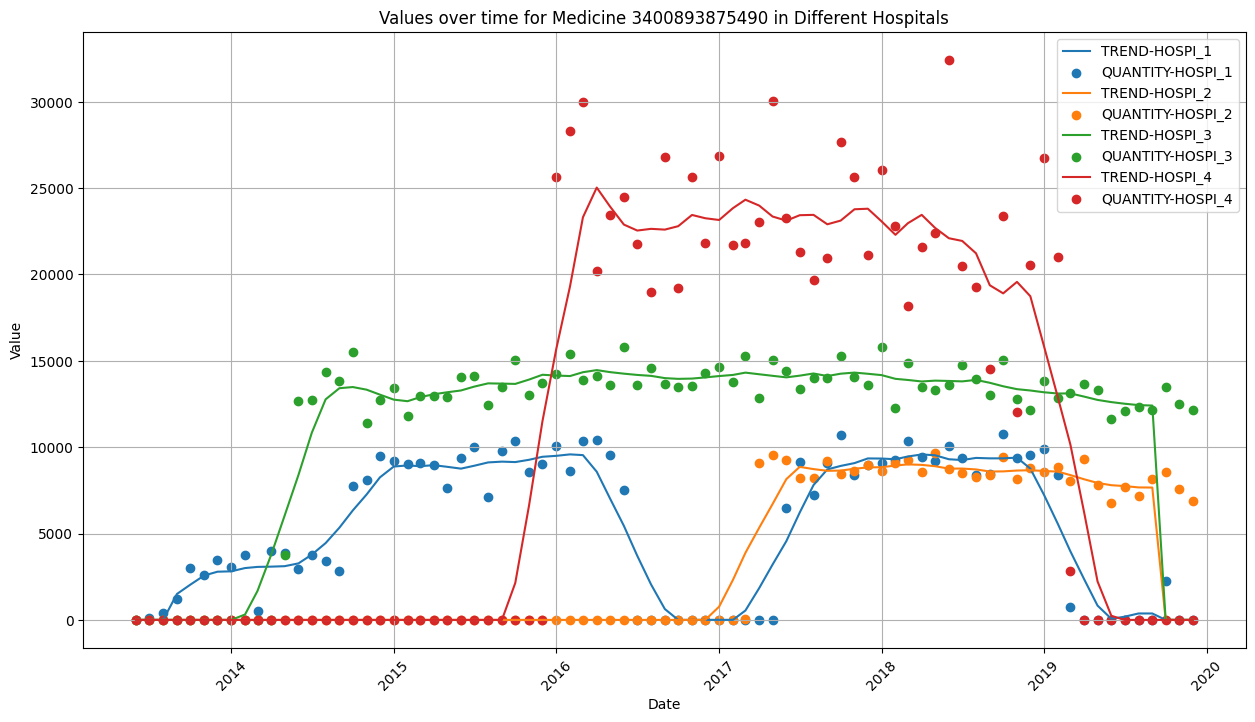

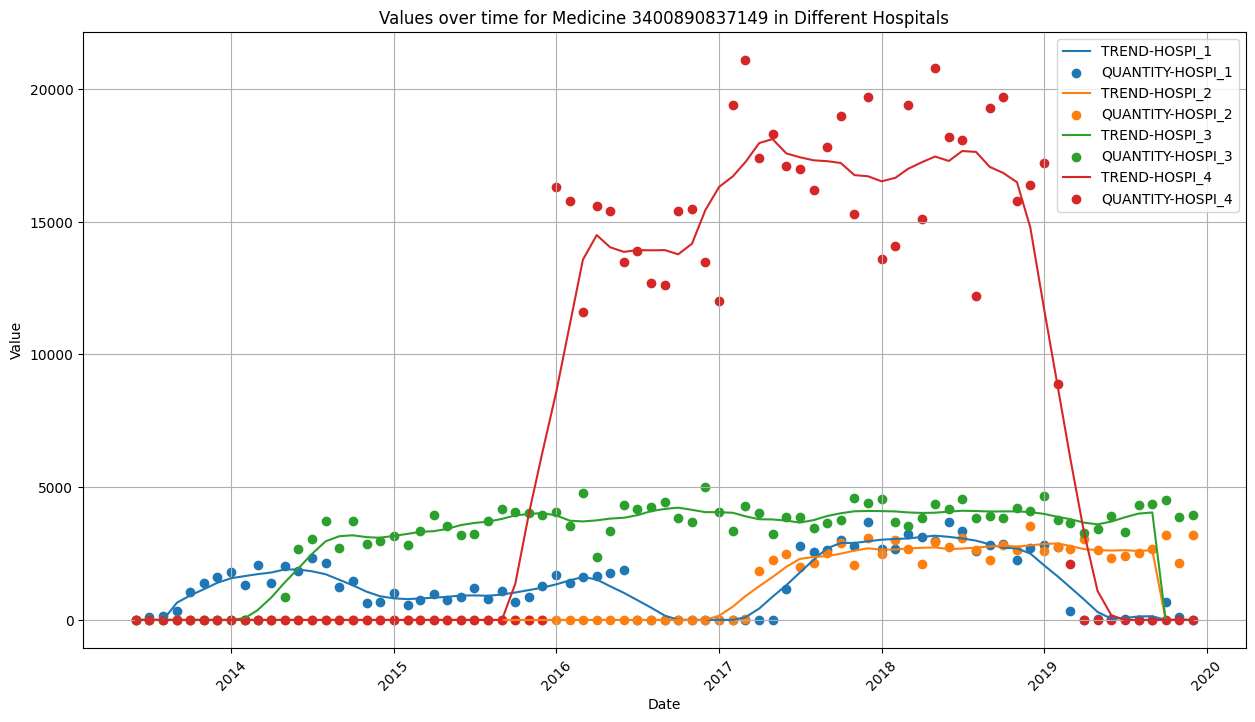

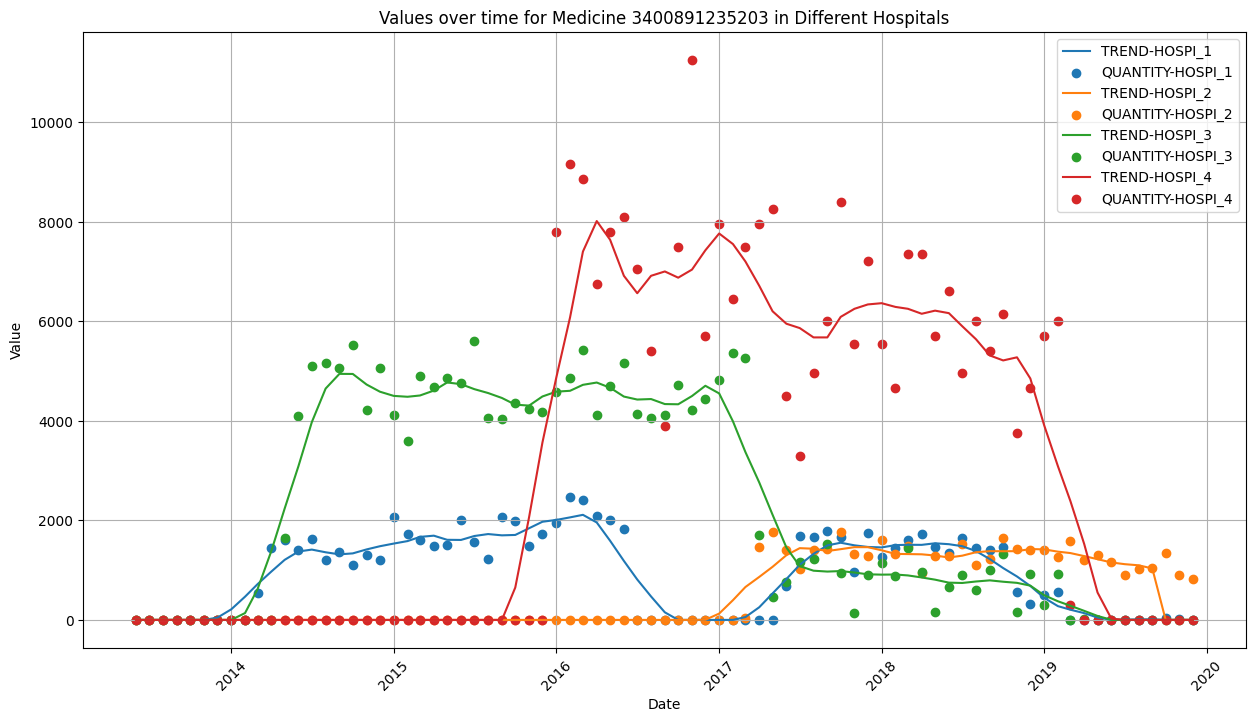

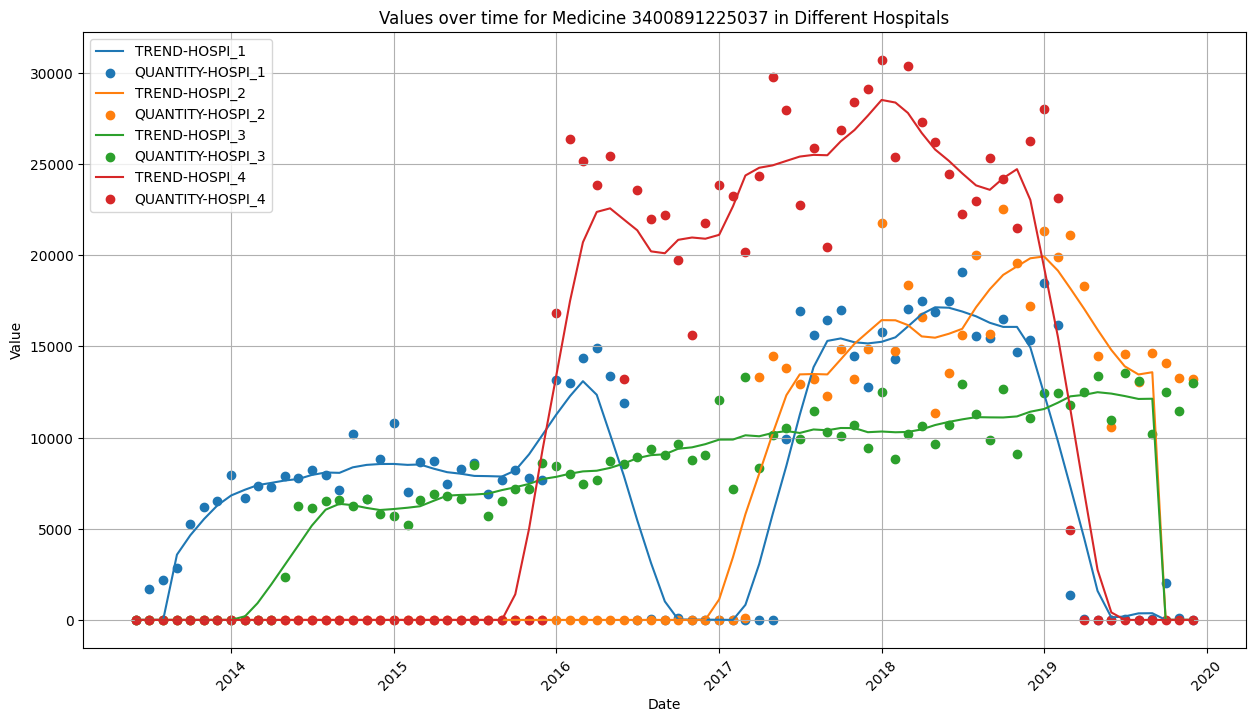

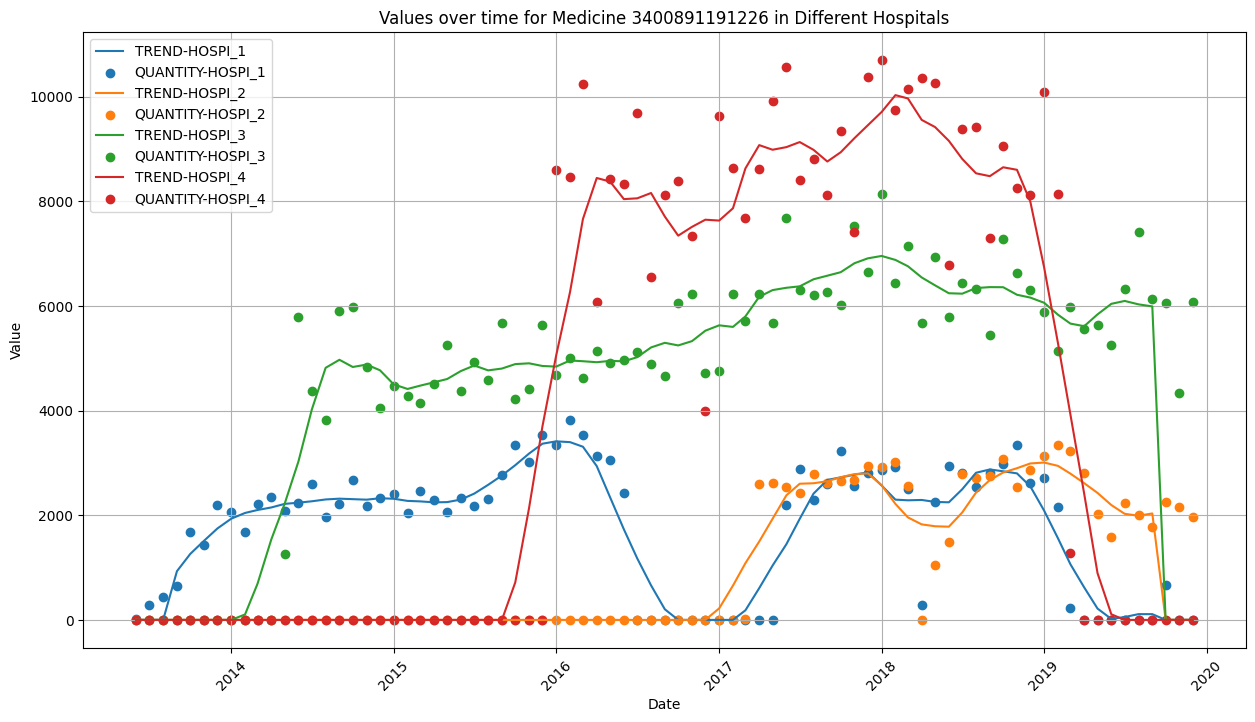

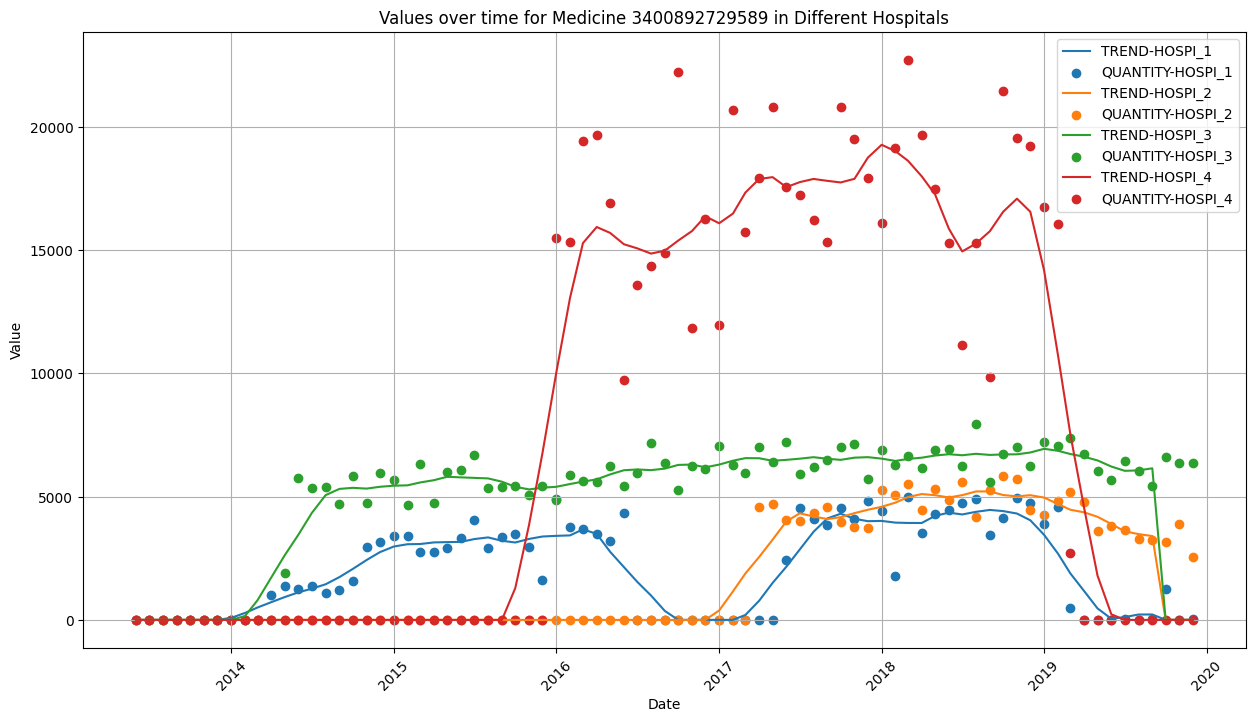

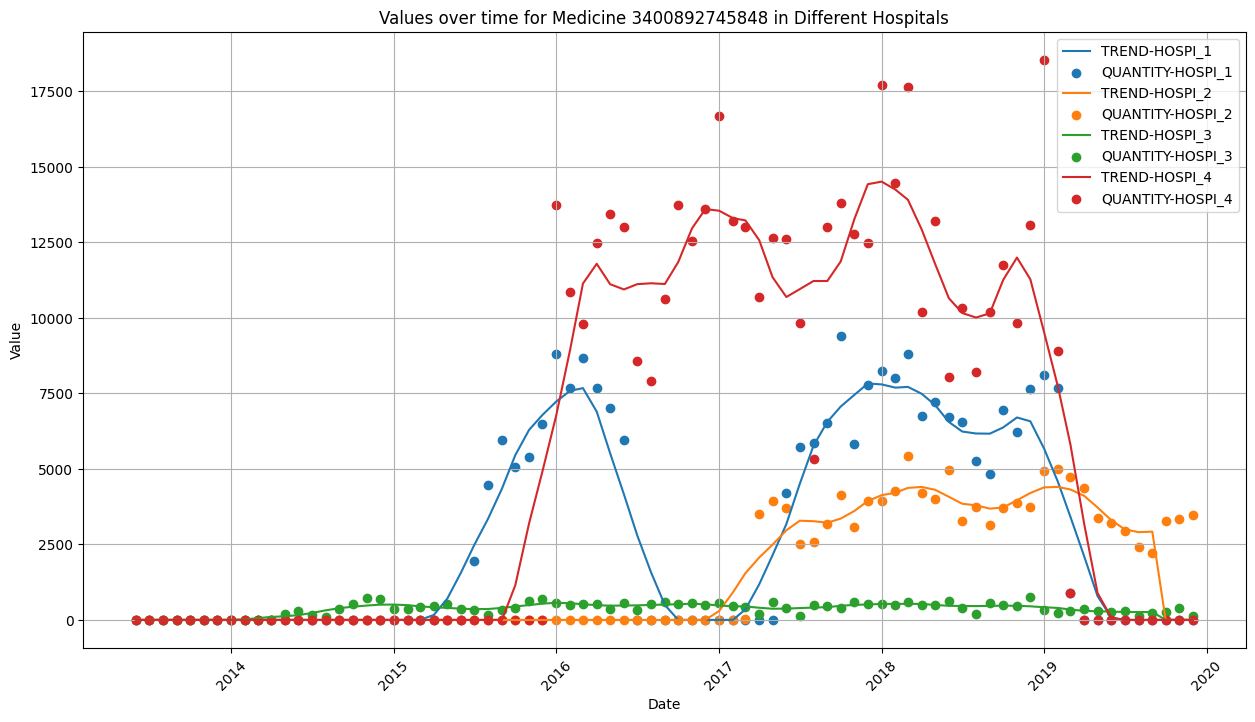

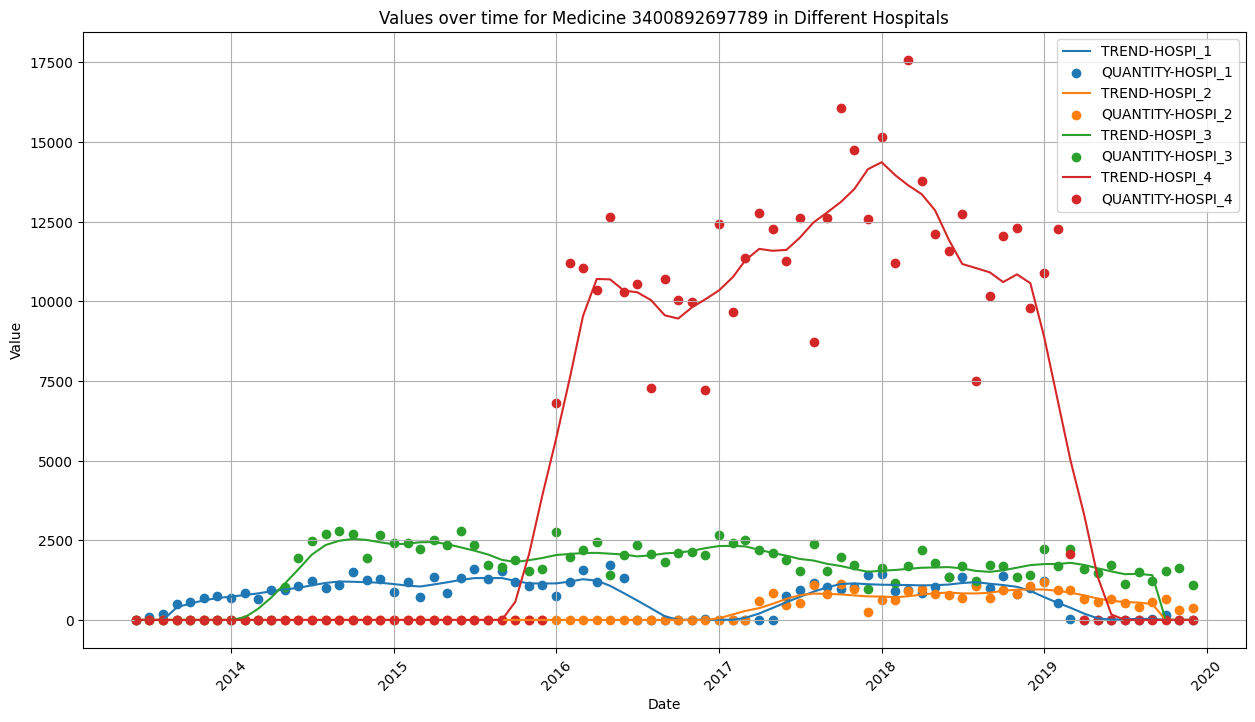

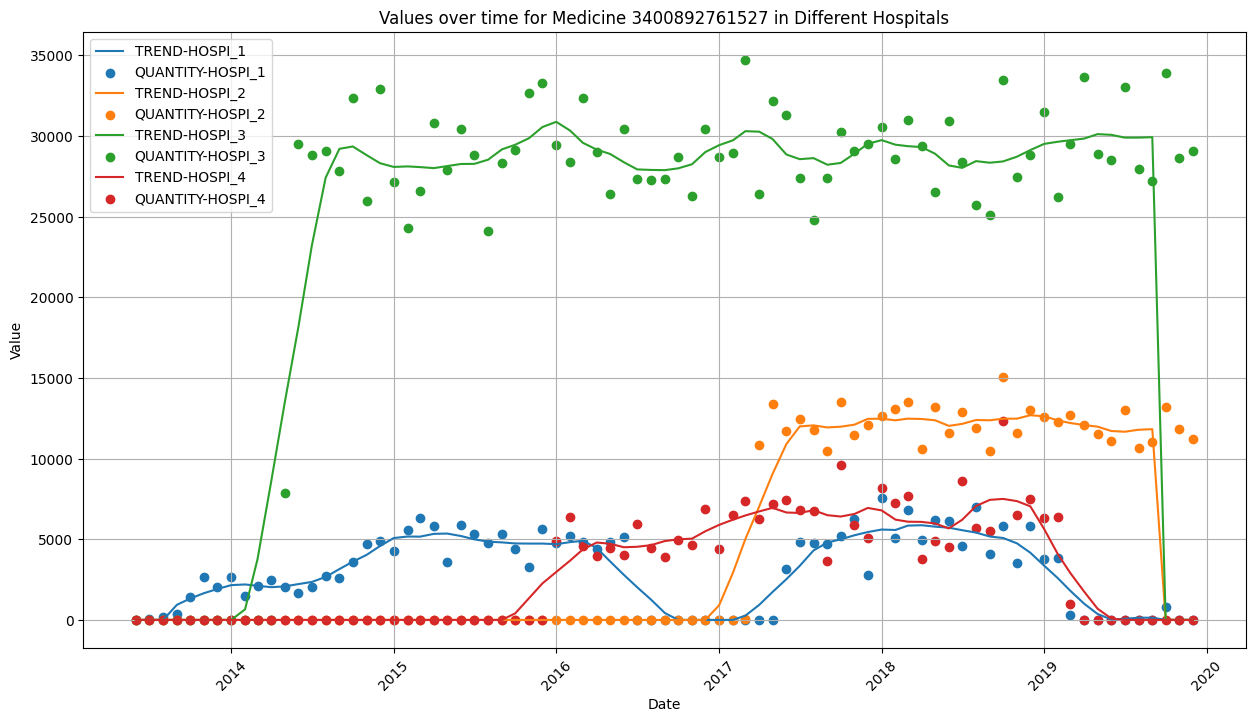

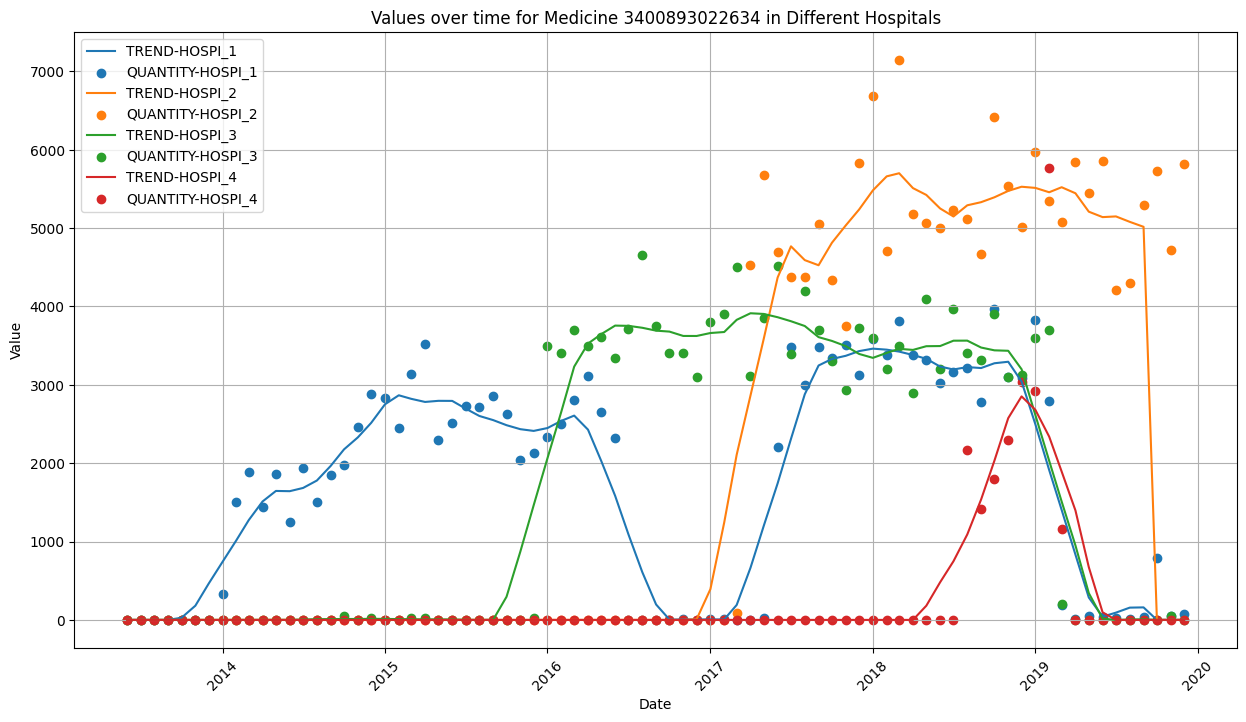

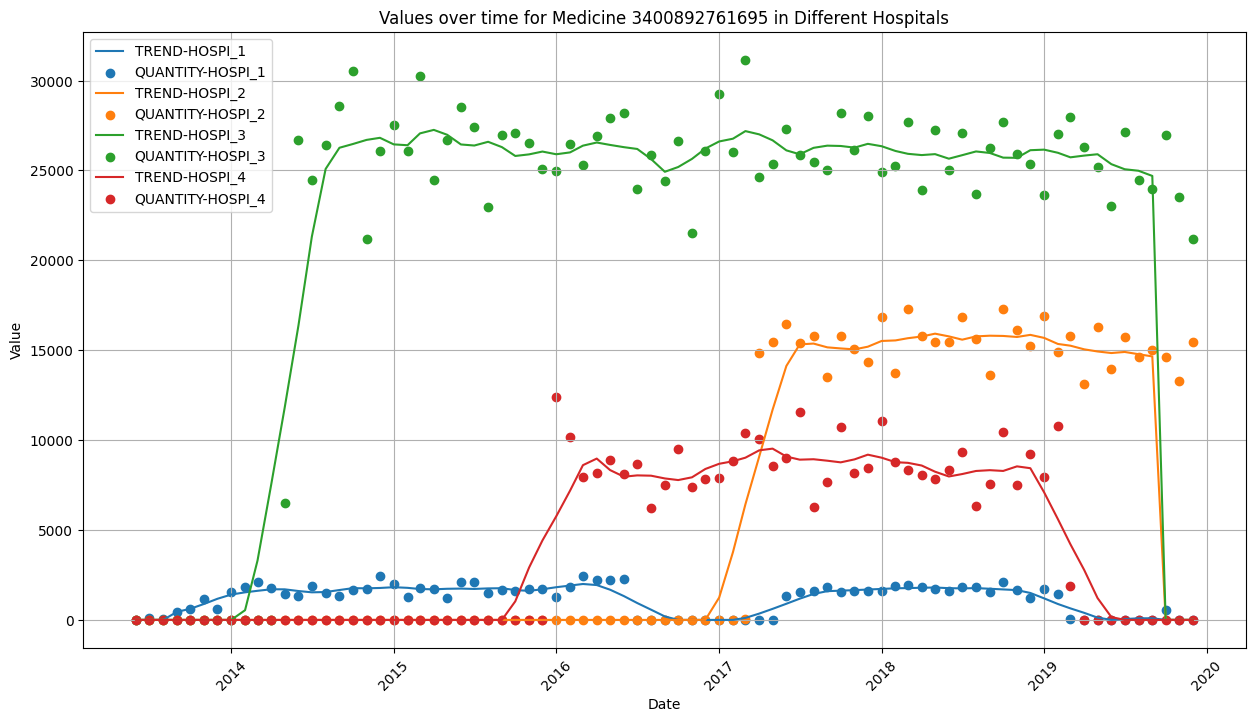

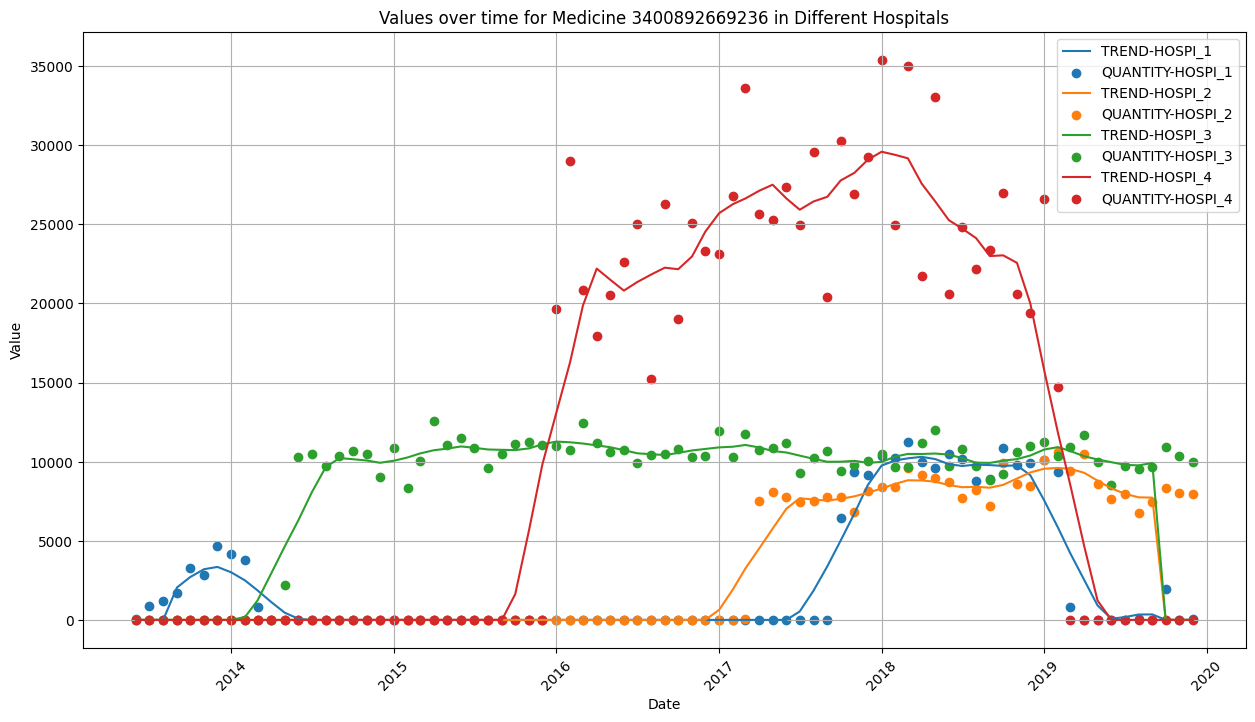

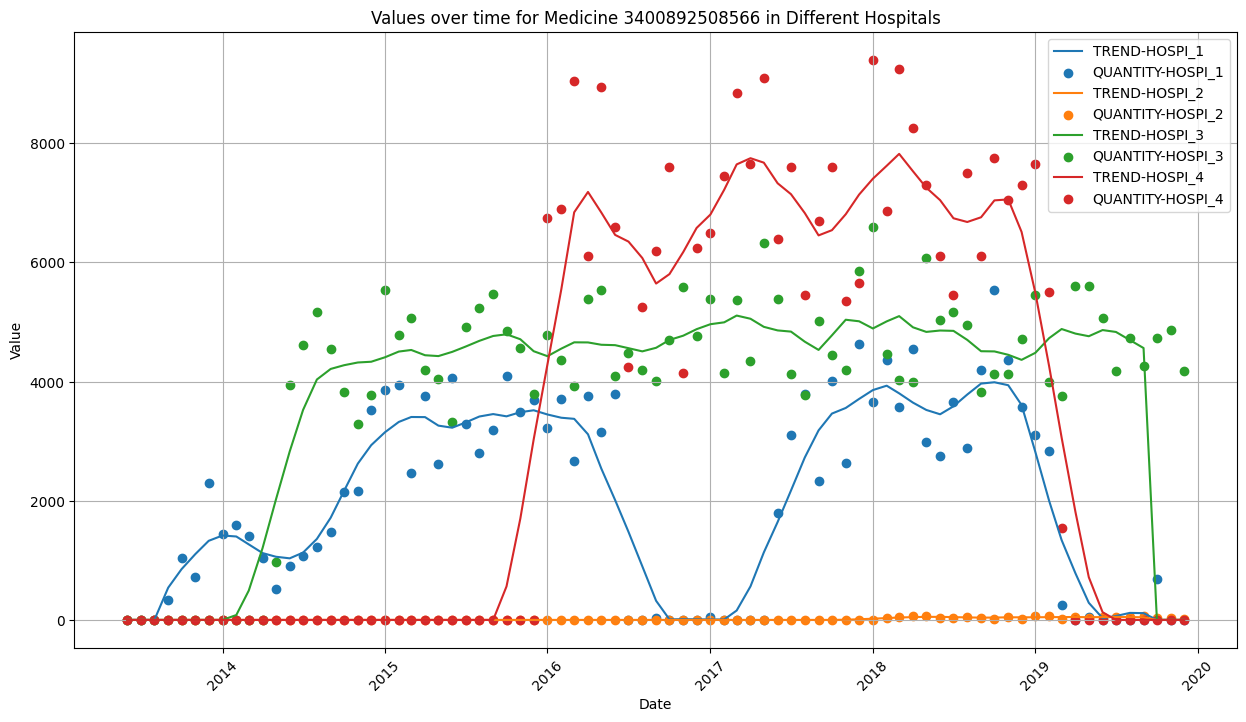

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

for medicine in medicines:
    fig, ax = plt.subplots(figsize=(15, 8))

    for hospi in ['HOSPI_1', 'HOSPI_2', 'HOSPI_3', 'HOSPI_4']:
        subset = df_ma_6[(df_ma_6["HOSPI_CODE_UCD"] == medicine) & (df_ma_6["ID_SITE_RATTACHE"] == hospi)].copy()
        subset['DATE'] = pd.to_datetime(subset['DATE'])
        x = subset["DATE"]
        y1 = subset['TREND']
        y3 = subset['QUANTITY']
        ax.plot(x, y1, label='TREND-' + hospi)
        ax.scatter(x, y3, label='QUANTITY-' + hospi)

    ax.set_xlabel('Date')
    ax.set_ylabel('Value')  # Replace with your actual ylabel
    ax.set_title(f'Values over time for Medicine {medicine} in Different Hospitals')
    ax.legend()

    # Set x-axis date locator and formatter
    date_locator = mdates.AutoDateLocator()
    date_formatter = mdates.AutoDateFormatter(date_locator)
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)

    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis tick labels
    ax.grid(True)

    plt.show()
    print()


In [58]:
import plotly.express as px
import pandas as pd

medicine = '3400891996128'
df_dol = df_ma_6[(df_ma_6['HOSPI_CODE_UCD'] == medicine) & (df_ma_6['QUANTITY'] > 0)][['ID_SITE_RATTACHE', 'QUANTITY', 'TREND','DATE']].copy()

# Define your time series
ts1 = df_dol[df_dol['ID_SITE_RATTACHE'] == 'HOSPI_1'][['DATE', 'TREND', 'QUANTITY']].copy()
ts2 = df_dol[df_dol['ID_SITE_RATTACHE'] == 'HOSPI_4'][['DATE', 'TREND', 'QUANTITY']].copy()

# Convert the time series to pandas datetime format
ts1['DATE'] = pd.to_datetime(ts1['DATE'])
ts2['DATE'] = pd.to_datetime(ts2['DATE'])

# Find the intersection of the two time series
common_period = ts1.merge(ts2, on='DATE', how='inner')

# Calculate the number of months in the common period
num_months = len(common_period)

# Check if the common period has at least 12 months
if num_months >= 12:
    print(f"There is a continuous shared period of {num_months} months.")
    start_date = common_period['DATE'].min()
    end_date = common_period['DATE'].max()

    fig = px.scatter(common_period, x='DATE', y=['QUANTITY_x', 'QUANTITY_y'],
                    labels={'QUANTITY_x': 'QUANTITY-HOSPI_1', 'QUANTITY_y': 'QUANTITY-HOSPI_2'},
                    title=f'Values over time for Medicine {medicine} in Different Hospitals')

    fig.add_trace(px.line(common_period, x='DATE', y='TREND_x').update_traces(line=dict(color='black')).data[0])
    fig.add_trace(px.line(common_period, x='DATE', y='TREND_y').update_traces(line=dict(color='red')).data[0])

    # Update the color of the traces
    color_discrete_map = {'TREND_x': 'red', 'TREND_y': 'blue', 'QUANTITY_x': 'green', 'QUANTITY_y': 'purple'}
    fig.update_traces(marker=dict(color='black'), selector=dict(name='QUANTITY_x'))
    fig.update_traces(marker=dict(color='red'), selector=dict(name='QUANTITY_y'))
    fig.update_traces(line=dict(color='black'), selector=dict(name='TREND_x'))
    fig.update_traces(line=dict(color='red'), selector=dict(name='TREND_y'))

    fig.update_xaxes(tickangle=45)
    fig.show()
else:
  print("There is no continuous shared period of at least 12 months.")


There is a continuous shared period of 28 months.


In [25]:
doliprane = '3400891996128'
df_dol = df_ma_6[(df_ma_6['HOSPI_CODE_UCD'] == doliprane) & (df_ma_6['QUANTITY'] > 0)][['ID_SITE_RATTACHE', 'QUANTITY', 'TREND','DATE']].copy()

df_dol[df_dol['ID_SITE_RATTACHE'] == 'HOSPI_2']['DATE'].values

array(['2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12'], dtype=object)

There is a continuous shared period of 27 months.
